## Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from src.model import LeNet5
from src.exp import run_experiment, run_experiment_all_optimizers
from src.hessian_helpers import *
from torch.optim import LBFGS, Adam

from optim_adahessian import Adahessian
from apollo import Apollo

import pandas as pd
import src.utils as utils

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import logging

from pyhessian import hessian
from density_plot import density_generate
import pickle
import copy
import numpy as np

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format="%(message)s")

%load_ext autoreload
%autoreload 2
%load_ext nb_black

Generating grammar tables from /home/.local/lib/python3.8/site-packages/blib2to3/Grammar.txt
Writing grammar tables to /home/.cache/black/21.6b0/Grammar3.8.8.final.0.pickle
Writing failed: [Errno 2] No such file or directory: '/home/.cache/black/21.6b0/tmp_5p3lyfj'
Generating grammar tables from /home/.local/lib/python3.8/site-packages/blib2to3/PatternGrammar.txt
Writing grammar tables to /home/.cache/black/21.6b0/PatternGrammar3.8.8.final.0.pickle
Writing failed: [Errno 2] No such file or directory: '/home/.cache/black/21.6b0/tmplonadox1'


<IPython.core.display.Javascript object>

## Loss Landscape (2D)

In [43]:
# Computes perturbations
datasets = ["MNIST", "Fashion_MNIST", "CIFAR"]
alphas, losses = [], {}
for dataset in datasets:
    results = pickle.load(open(f"/home/app/results/{dataset}_results.dic", "rb"))
    losses[dataset] = {}
    for optimizer in results[dataset].keys():
        alphas, loss = compute_minimum_shape(
            results[dataset][optimizer]["model"], dataset, use_3d=False
        )
        losses[dataset][optimizer] = np.array(loss)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>

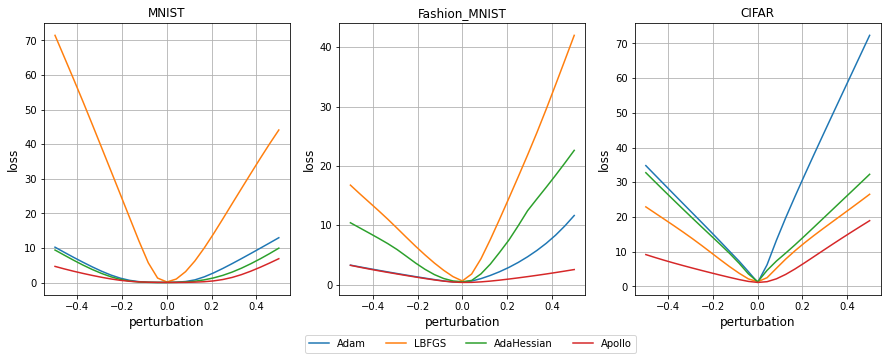

<IPython.core.display.Javascript object>

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, (dataset, v) in enumerate(losses.items()):
    for optimizer, loss in v.items():
        axs[i].plot(alphas, loss)
        axs[i].set_title(dataset)
        axs[i].set_xlabel("perturbation", size="large")
        axs[i].set_ylabel("loss", size="large")
        axs[i].grid(True)

fig.legend(
    ["Adam", "LBFGS", "AdaHessian", "Apollo"],
    loc="lower center",
    bbox_to_anchor=(0.52, -0.05),
    ncol=4,
)


fig.savefig("/home/app/results/loss_landscape", bbox_inches="tight")

<IPython.core.display.Javascript object>

## Loss Landscape (3D)

In [124]:
# Computes perturbations
datasets = ["MNIST", "Fashion_MNIST", "CIFAR"]
alphas, losses_3d = [], {}
for dataset in datasets:
    results = pickle.load(open(f"{dataset}_results.dic", "rb"))
    losses_3d[dataset] = {}
    for optimizer in results[dataset].keys():
        alphas, loss = compute_minimum_shape(
            results[dataset][optimizer]["model"], dataset, use_3d=True
        )
        losses_3d[dataset][optimizer] = np.array(loss).reshape(len(alphas), -1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>

### MNIST

In [137]:
losses_3d = losses

<IPython.core.display.Javascript object>

In [157]:
# Different colormaps for different optimizers
dataset = "MNIST"
colors = ["ylgn", "viridis", "blues", "plotly3"]
fig = go.Figure()

for (optimizer, loss), c in zip(losses_3d[dataset].items(), colors):
    fig.add_trace(
        go.Surface(
            z=loss,
            x=alphas,
            y=alphas,
            opacity=0.7,
            name=optimizer,
            showscale=False,
            showlegend=True,
            colorscale=c,
        ),
    )

fig.update_layout(
    title=f"Loss landscape for {dataset}",
    autosize=True,
    margin=dict(l=65, r=50, b=65, t=90),
    xaxis_title="Perturbation in first eigenvector direction",
    yaxis_title="Perturbation in second eigenvector direction",
    overwrite=True,
)
fig.show()


<IPython.core.display.Javascript object>

### Fashion-MNIST

In [159]:
# Different colormaps for different optimizers
dataset = "Fashion_MNIST"
colors = ["ylgn", "viridis", "blues", "plotly3"]
fig = go.Figure()

for (optimizer, loss), c in zip(losses_3d[dataset].items(), colors):
    fig.add_trace(
        go.Surface(
            z=loss,
            x=alphas,
            y=alphas,
            opacity=0.7,
            name=optimizer,
            showscale=False,
            showlegend=True,
            colorscale=c,
        ),
    )

fig.update_layout(
    title=f"Loss landscape for {dataset}",
    autosize=True,
    margin=dict(l=65, r=50, b=65, t=90),
    xaxis_title="Perturbation in first eigenvector direction",
    yaxis_title="Perturbation in second eigenvector direction",
    overwrite=True,
)
fig.show()

<IPython.core.display.Javascript object>

### CIFAR

In [160]:
# Different colormaps for different optimizers
dataset = "CIFAR"
colors = ["ylgn", "viridis", "blues", "plotly3"]
fig = go.Figure()

for (optimizer, loss), c in zip(losses_3d[dataset].items(), colors):
    fig.add_trace(
        go.Surface(
            z=loss,
            x=alphas,
            y=alphas,
            opacity=0.7,
            name=optimizer,
            showscale=False,
            showlegend=True,
            colorscale=c,
        ),
    )

fig.update_layout(
    title=f"Loss landscape for {dataset}",
    autosize=True,
    margin=dict(l=65, r=50, b=65, t=90),
    xaxis_title="Perturbation in first eigenvector direction",
    yaxis_title="Perturbation in second eigenvector direction",
    overwrite=True,
)
fig.show()

<IPython.core.display.Javascript object>

## Hessian traces

In [40]:
datasets = ["MNIST", "Fashion_MNIST", "CIFAR"]
traces = {}
for dataset in datasets:
    results = pickle.load(open(f"/home/app/results/{dataset}_results.dic", "rb"))
    traces[dataset] = {}
    for optimizer in results[dataset].keys():
        trace = compute_hessian_trace(results[dataset][optimizer]["model"], dataset)
        traces[dataset][optimizer] = np.array(trace)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>

In [41]:
pd.DataFrame(
    np.array(
        [
            [(dataset, optimizer, np.sum(trace)) for optimizer, trace in v.items()]
            for dataset, v in traces.items()
        ]
    ).reshape(12, -1),
    columns=["Dataset", "Optimizer", "Trace"],
).sort_values(by="Optimizer")

,Dataset,Optimizer,Trace
2,MNIST,AdaHessian,2281.419990539551
6,Fashion_MNIST,AdaHessian,43558.05355834961
10,CIFAR,AdaHessian,377798.77252197266
0,MNIST,Adam,4333.956886291504
4,Fashion_MNIST,Adam,16188.822402954102
8,CIFAR,Adam,210134.19189453125
3,MNIST,Apollo,438.83083724975586
7,Fashion_MNIST,Apollo,8025.53524017334
11,CIFAR,Apollo,13266.279052734375
1,MNIST,LBFGS,101336.79260253906


<IPython.core.display.Javascript object>

## Eigenvalue Spectral Density

In [ ]:
datasets = ["MNIST", "Fashion_MNIST", "CIFAR"]
esds = {}
for dataset in datasets:
    results = pickle.load(open(f"{dataset}_results.dic", "rb"))
    esds[dataset] = {}
    for optimizer in results[dataset].keys():
        esd = compute_esd(results[dataset][optimizer]["model"], dataset)
        esds[dataset][optimizer] = esd

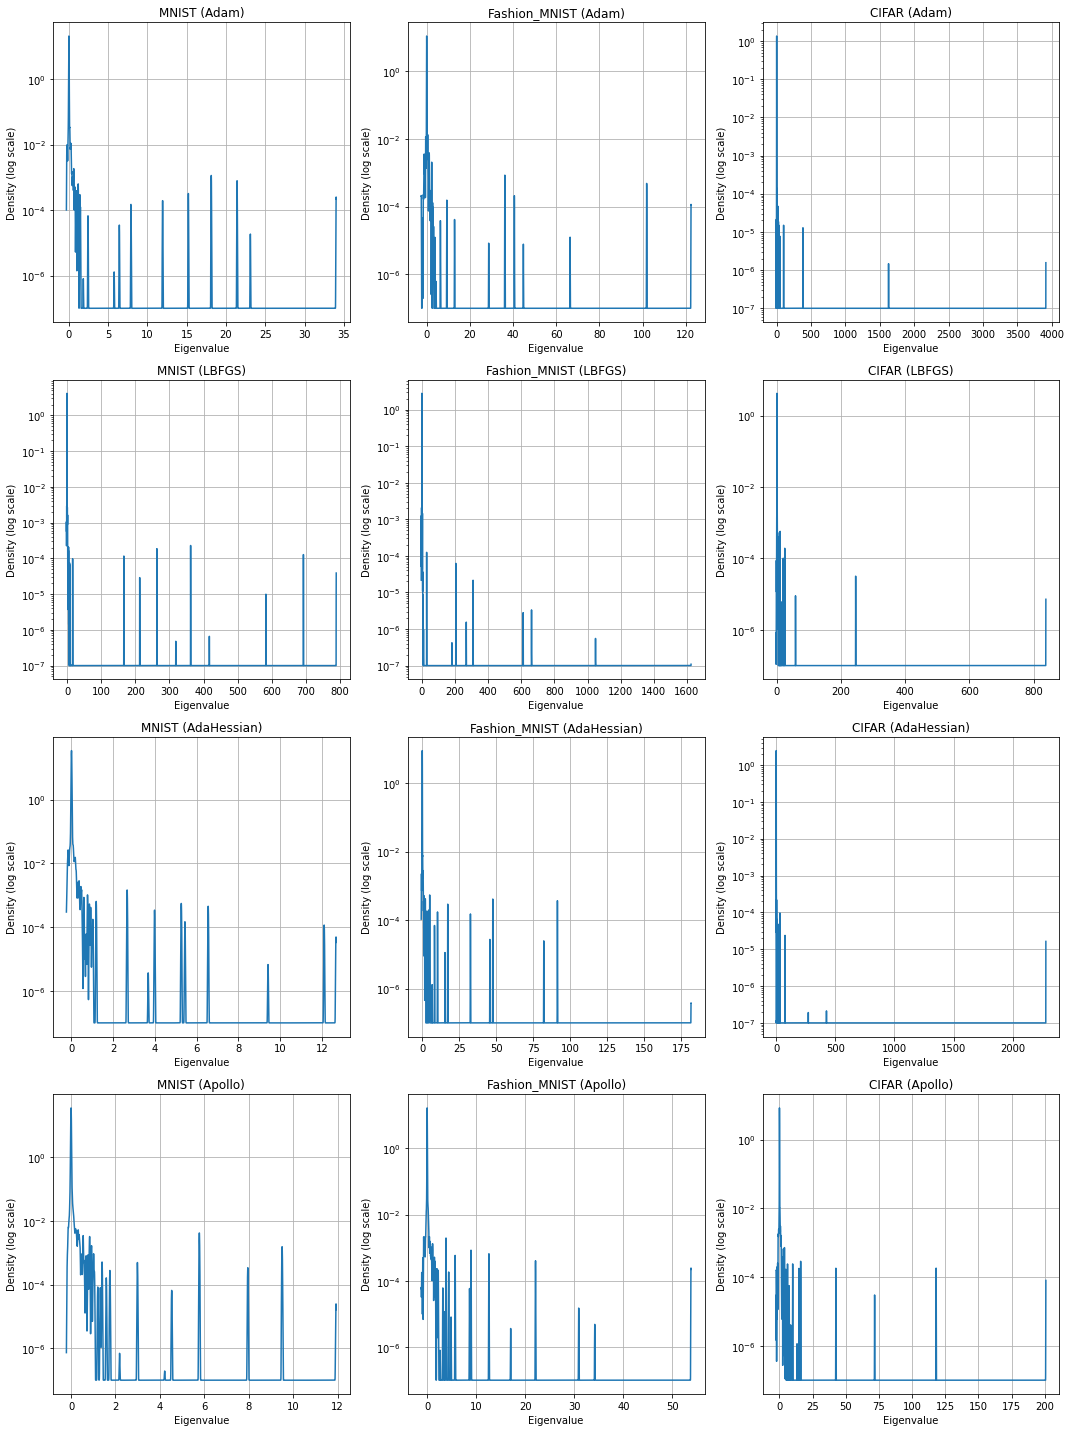

<IPython.core.display.Javascript object>

In [33]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
for i, (dataset, v) in enumerate(esds.items()):
    for j, (optimizer, esd) in enumerate(v.items()):
        density, grids = density_generate(esd[0], esd[1])
        axs[j, i].plot(grids, density + 1.0e-7)
        axs[j, i].semilogy(True)
        axs[j, i].set_title(f"{dataset} ({optimizer})")
        axs[j, i].set_xlabel("Eigenvalue")
        axs[j, i].set_ylabel("Density (log scale)")
        axs[j, i].grid(True)

fig.tight_layout()
fig.show()